In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib inline
import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

In [2]:
# Configs ----------------------------------------------------------------------

# takes only current needed GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# random numbers
random_seed = np.random.randint(1, 1e5)
rng = np.random.RandomState(random_seed)

In [3]:
# Utils ------------------------------------------------------------------------

def mackey_glass(stime = 30000, dt = 0.05,
        beta = 2., gamma = 1., n = 9.65, tau = 2):
    d = int(tau/dt)    
    x = 3.0*np.ones(2*stime + d)
    for t in range(tau-1, 2*stime):
        x[t+1] = x[t] + dt*(
                beta*x[t-d] / (1.0 + x[t-d]**n)
                - gamma*x[t] )
    return x[2*d: stime + 2*d], d

def mult_sines(stime = 1200):
    res = np.arange(stime)
    res = np.sin(res) + np.sin(0.51*res) \
        + np.sin(0.22*res) \
        + np.sin(0.1002*res) \
        + np.sin(0.05343*res)
    
    res -= res.min() 
    res /= res.max()
    
    return res

def MSE(P, Y):
    return tf.reduce_mean(tf.squared_difference(P, Y)) 

def NRMSE(P, Y):
    return tf.sqrt( MSE(P, Y)) / (tf.reduce_max(Y) - tf.reduce_min(Y))
   
def ridge_regression(X, Y, num_units, lmb):
    return tf.matmul( tf.matrix_inverse(
        tf.matmul(tf.transpose(X), X) + lmb*tf.eye(num_units)),
              tf.matmul(tf.transpose(X), Y))


In [4]:
# Global variables --------------------------------------------------------------

batches = 1
stime = 700
num_units = 20
num_inputs = 1
lr = 0.0001
lmb_init = 0.0995
timewindow_begin = 50
timewindow_end = stime

# the activation function of the ESN
out_function = lambda x:  math_ops.tanh(x)


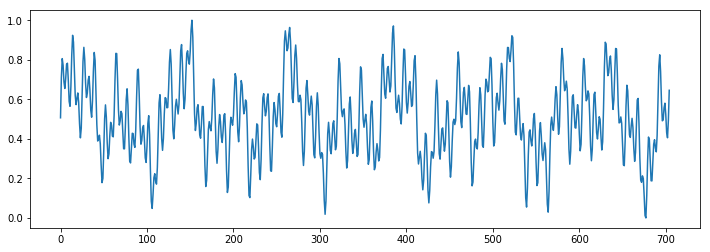

In [5]:
# input -------------------------------------------------------------------------
rnn_inputs = np.zeros((batches, stime, num_inputs), dtype="float32")
wave = mult_sines(stime+5).astype("float32")
rnn_inputs = wave[5:].reshape(1,stime, 1)
rnn_init_state = np.zeros([batches, num_units], dtype="float32")
plt.figure(figsize=(12,4))
wave_line, = plt.plot(wave)

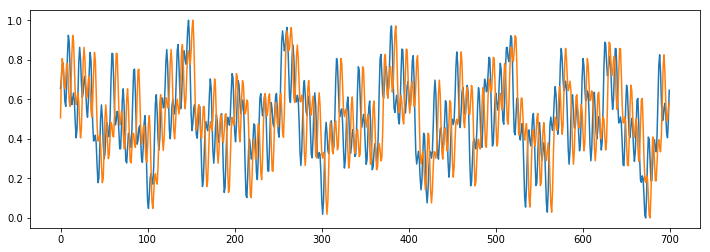

In [6]:
# the output target - mackey-glass ----------------------------------------------
rnn_target = wave[:-5]
rnn_target = rnn_target.reshape(stime, 1).astype("float32")
plt.figure(figsize=(12,4))
inp_line, = plt.plot(rnn_inputs[0,:,:])
targ_line, = plt.plot(rnn_target)


In [7]:
# tensorflow graph -------------------------------------------------------------
  
def initialize_ESN(num_units, out_function, rng, decay=0.15, 
                    alpha=0.5, optimize=True):


    print("Making ESN init graph ...")
    cell = EchoStateRNNCell(num_units=num_units, 
                            activation=out_function, 
                            decay=0.15, 
                            alpha=0.5,
                            rng=rng, 
                            optimize=True,
                            optimize_vars=["rho", "decay","alpha", "sw"])
    print("Done")
    return cell
    
def ESN_activation(cell, init_state, stime, num_units):
    print("Making ESN spreading graph ...")
    states = []
    state = init_state
    for t in range(stime):
        state,_ = cell(inputs=inputs[0,t:(t+1),:], state=state)
        states.append(state)
    outputs = tf.reshape(states, [stime, num_units])   
    print ("Done")
    return outputs

def do_regression(output_slice, target_slice, num_units, lmb):
    # do the regression on a training subset of the timeseries
    print("Making regression graph ...")       
    readout_weights = ridge_regression(output_slice, target_slice,
                                       num_units, lmb)
    print("Done")
    return readout_weights


def readout_activation(outputs, readout_weights):   
    print("Making readout spreading graph ...")
    readouts = tf.matmul(outputs, readout_weights)
    print("Done") 
    return readouts
    
    
def training(target_slice, readouts_slice, cell, lr, optimize_alpha=True):
    print("Making training graph ...")    
    # calculate the loss over all the timeseries (escluded the beginning
    nrmse = NRMSE(target_slice, readouts_slice) 
    loss = MSE(target_slice, readouts_slice) 

    try: # if optimize == True
        var_list = [cell.rho, cell.decay, cell.sw, lmb]
        if optimize_alpha :
            var_list.append(cell.alpha)
        optimizer = tf.train.AdamOptimizer(lr)
        train = optimizer.minimize(loss, var_list=var_list)
        
    except ValueError: # if optimize == False
        train = tf.get_variable("trial", (), dtype=None)
    print("Done")    
        
    return nrmse, loss, train
    
def clipping(cell):
    # clip values
    clip_rho = cell.rho.assign(tf.clip_by_value(cell.rho, 0.8, 5.0))
    clip_alpha = cell.alpha.assign(tf.clip_by_value(cell.alpha, 0.0, 1.0))
    clip_decay = cell.decay.assign(tf.clip_by_value(cell.decay, 0.1, 0.25))
    clip_sw = cell.sw.assign(tf.clip_by_value(cell.sw, 0.0001, 10.0))
    clip_lmb = lmb.assign(tf.clip_by_value(lmb, 0.001, 0.2))
    clip = tf.group(clip_rho, clip_alpha, clip_decay, clip_sw, clip_lmb)   
    return clip

def make_graph(num_units, out_function, init_state, stime, lmb, lr):
    cell = initialize_ESN(num_units, out_function, rng)
    outputs = ESN_activation(cell, init_state, stime, num_units)  
    output_slice = outputs[timewindow_begin:timewindow_end,:]
    target_slice = target[timewindow_begin:timewindow_end,:]
    readout_weights = do_regression(output_slice, target_slice, num_units, lmb)
    readouts = readout_activation(outputs, readout_weights)
    readoutputs_slice = readouts[timewindow_begin:timewindow_end,:]
    nrmse, loss, train = training(target_slice, readoutputs_slice, cell, lr)
    clip = clipping(cell)
    return cell, outputs, readouts, nrmse, loss, train, clip

In [8]:
tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default() as g:
          
    # Build the graph
    inputs = tf.placeholder(tf.float32, [batches, stime, num_inputs])
    target = tf.placeholder(tf.float32, [stime, 1])
    init_state = tf.placeholder(tf.float32, [1, num_units])   
    lmb = tf.get_variable("lmb", initializer=lmb_init, 
                          dtype=tf.float32, trainable=True)
    

    cell, outputs, readouts, nrmse, loss, train, clip = make_graph(
        num_units, out_function, init_state, stime, lmb, lr)
    

Making ESN init graph ...
Done
Making ESN spreading graph ...
Done
Making regression graph ...
Done
Making readout spreading graph ...
Done
Making training graph ...
Done


In [9]:
# run session -----------------------------------------------------------------
with graph.as_default() as g:

    trials = 20000
    with tf.Session(config=config) as session:
        session.run(tf.global_variables_initializer())
        losses = np.zeros(trials)
        print("Executing the graph")
        for k in range(trials):
            
            rho, alpha, decay, sw, U, curr_outputs, curr_readouts,curr_loss,curr_nrmse,_= \
                    session.run([cell.rho, cell.alpha, cell.decay, cell.sw, 
                                 cell.U, outputs, readouts, loss, nrmse, train ], 
                                feed_dict={inputs:rnn_inputs, target: rnn_target,
                                           init_state:rnn_init_state})
            
            session.run(clip)
            
            if k%2000 == 0 or k == trials-1:
                sys.stdout.write("step: {:4d}\t".format(k))
                sys.stdout.write("NRMSE: {:5.3f}\t".format(curr_nrmse))
                sys.stdout.write("rho: {:5.3f}\t".format(rho))
                sys.stdout.write("alpha: {:5.3f}\t".format(alpha))
                sys.stdout.write("decay: {:5.3f}\t".format(decay))
                sys.stdout.write("sw: {:5.3f}\t".format(sw))
                sys.stdout.write("lmb: {:5.3f}\n".format(lmb.eval()))

            losses[k] = curr_nrmse
        print("Done")


Executing the graph
step:    0	NRMSE: 0.151	rho: 1.000	alpha: 0.500	decay: 0.150	sw: 1.000	lmb: 0.099
step: 2000	NRMSE: 0.037	rho: 1.066	alpha: 0.392	decay: 0.250	sw: 0.905	lmb: 0.001
step: 4000	NRMSE: 0.031	rho: 1.085	alpha: 0.387	decay: 0.250	sw: 0.788	lmb: 0.001
step: 6000	NRMSE: 0.027	rho: 1.087	alpha: 0.383	decay: 0.250	sw: 0.703	lmb: 0.001
step: 8000	NRMSE: 0.024	rho: 1.081	alpha: 0.374	decay: 0.250	sw: 0.618	lmb: 0.001
step: 10000	NRMSE: 0.022	rho: 1.068	alpha: 0.375	decay: 0.250	sw: 0.549	lmb: 0.001
step: 12000	NRMSE: 0.020	rho: 1.060	alpha: 0.378	decay: 0.250	sw: 0.490	lmb: 0.001
step: 14000	NRMSE: 0.019	rho: 1.048	alpha: 0.377	decay: 0.250	sw: 0.452	lmb: 0.001
step: 16000	NRMSE: 0.019	rho: 1.043	alpha: 0.379	decay: 0.250	sw: 0.420	lmb: 0.001
step: 18000	NRMSE: 0.018	rho: 1.033	alpha: 0.377	decay: 0.250	sw: 0.397	lmb: 0.001
step: 19999	NRMSE: 0.018	rho: 1.038	alpha: 0.379	decay: 0.250	sw: 0.379	lmb: 0.001
Done


NameError: name 'begin' is not defined

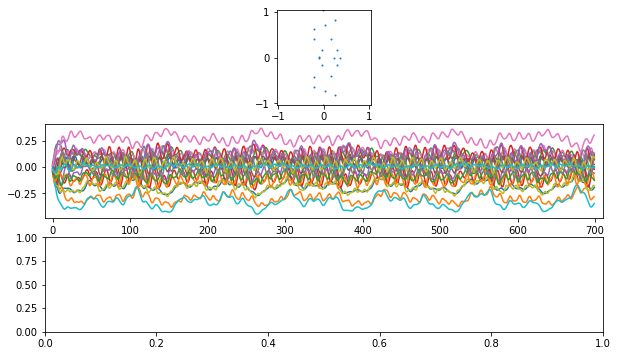

In [12]:
    # plot results ---------------------------------------------------------------
    
    plt.figure(figsize=(10,8))
    plt.subplot(411, aspect="equal")
    eigs = np.linalg.eigvals(U*rho)
    plt.scatter(eigs.real, eigs.imag, s=1)
    plt.xlim([-rho, rho])
    plt.ylim([-rho, rho])
    plt.subplot(412)
    plt.plot(curr_outputs)
    plt.xlim([-10, stime+10])
    plt.subplot(413)
    plt.plot(range(begin,end),rnn_target[begin:end,:], 
            color="green", lw=6, alpha=0.5)
    plt.plot(rnn_target, color="red", alpha=0.5)
    plt.plot(curr_readouts, color="blue", lw=0.5)
    plt.xlim([-10, stime+10])
    plt.subplot(414)
    plt.plot(losses)
    plt.show()
